## ECG Anomaly Detection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
seed(10)
tf.random.set_seed(10)


In [ ]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing

In [ ]:
# The ECG dataset containing a single anomaly corresponding to a pre-ventricular contraction
# dataset from http://www.cs.ucr.edu/~eamonn/discords/
import pickle
train_data_dir= '/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275_train.pkl'
test_data_dir= '/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275_test.pkl'
with open(train_data_dir, 'rb') as f:
    train_raw = pickle.load(f)
with open(test_data_dir, 'rb') as f:
    test_raw = pickle.load(f)

In [ ]:
#only use target 1 & target 2
train = pd.DataFrame(train_raw,columns=['Target1','Target2','label']).iloc[:,:2]
test = pd.DataFrame(test_raw,columns=['Target1','Target2','label']).iloc[:,:2]

In [ ]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1833, 2)
Test dataset shape: (1841, 2)


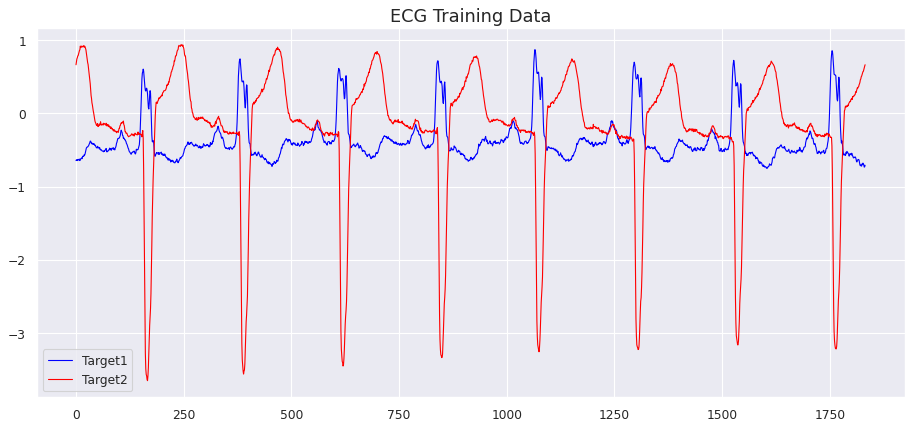

In [ ]:
# train data plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(train['Target2'], label='Target2', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('ECG Training Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275.txt"
joblib.dump(scaler, scaler_filename)

['/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275.txt']

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1833, 1, 2)
Test data shape: (1841, 1, 2)


In [ ]:
print(X_train)

[[[0.06481481 0.94015234]]

 [[0.07098765 0.94994559]]

 [[0.06481481 0.95756257]]

 ...

 [[0.00925926 0.93144723]]

 [[0.01234568 0.93579978]]

 [[0.02469136 0.94015234]]]


In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(24, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 24)             2592      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1400      
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 10)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 10)             840       
                                                                 
 lstm_3 (LSTM)               (None, 1, 24)             3360      
                                                             

In [ ]:
# fit the model to the data
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
88/88 [==============================] - 10s 26ms/step - loss: 0.4272 - val_loss: 0.3784
Epoch 2/100
88/88 [==============================] - 1s 8ms/step - loss: 0.2572 - val_loss: 0.2008
Epoch 3/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0954 - val_loss: 0.1838
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0854 - val_loss: 0.1622
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0734 - val_loss: 0.1448
Epoch 6/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0686 - val_loss: 0.1396
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0644 - val_loss: 0.1306
Epoch 8/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0608 - val_loss: 0.1209
Epoch 9/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0563 - val_loss: 0.1117
Epoch 10/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0533 - val_loss: 0.1034
Epoch 1

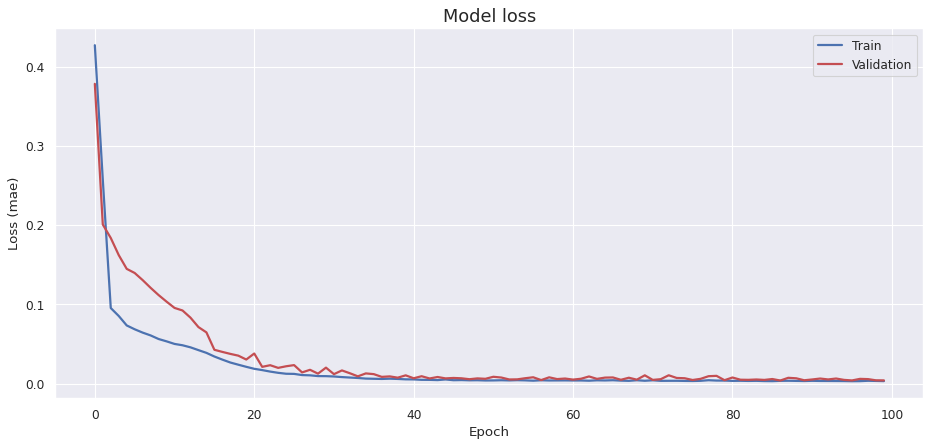

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function

58/58 [==============================] - 1s 2ms/step


(0.0, 0.1)

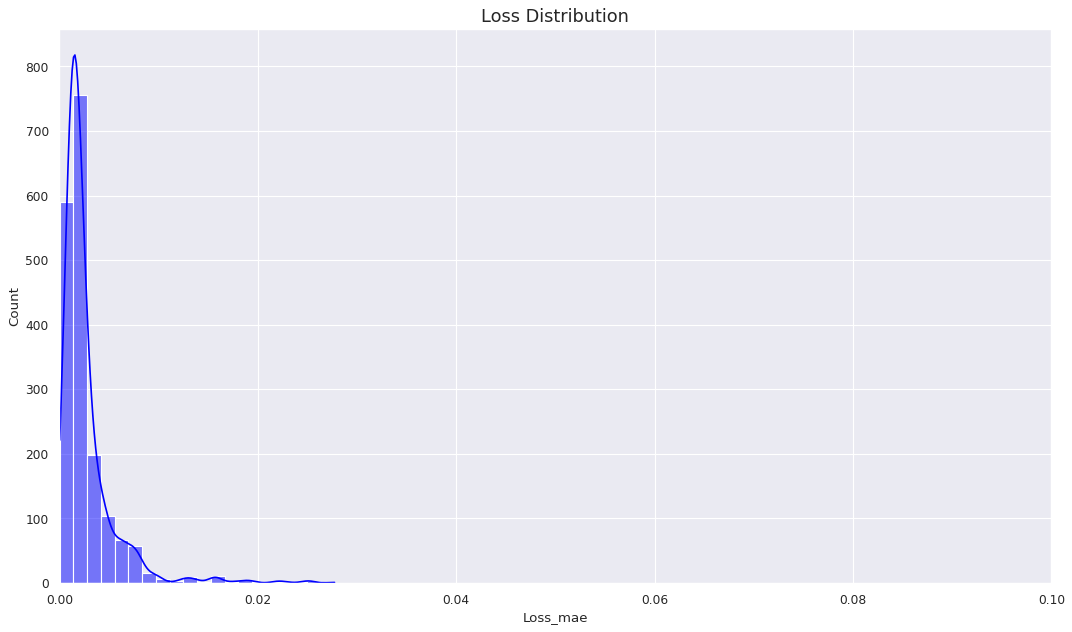

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [ ]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.02774048023436615
58/58 [==============================] - 0s 2ms/step


,Loss_mae,Threshold,Anomaly
0,0.001373,0.02774,False
1,0.001732,0.02774,False
2,0.002363,0.02774,False
3,0.001939,0.02774,False
4,0.002044,0.02774,False


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:695: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

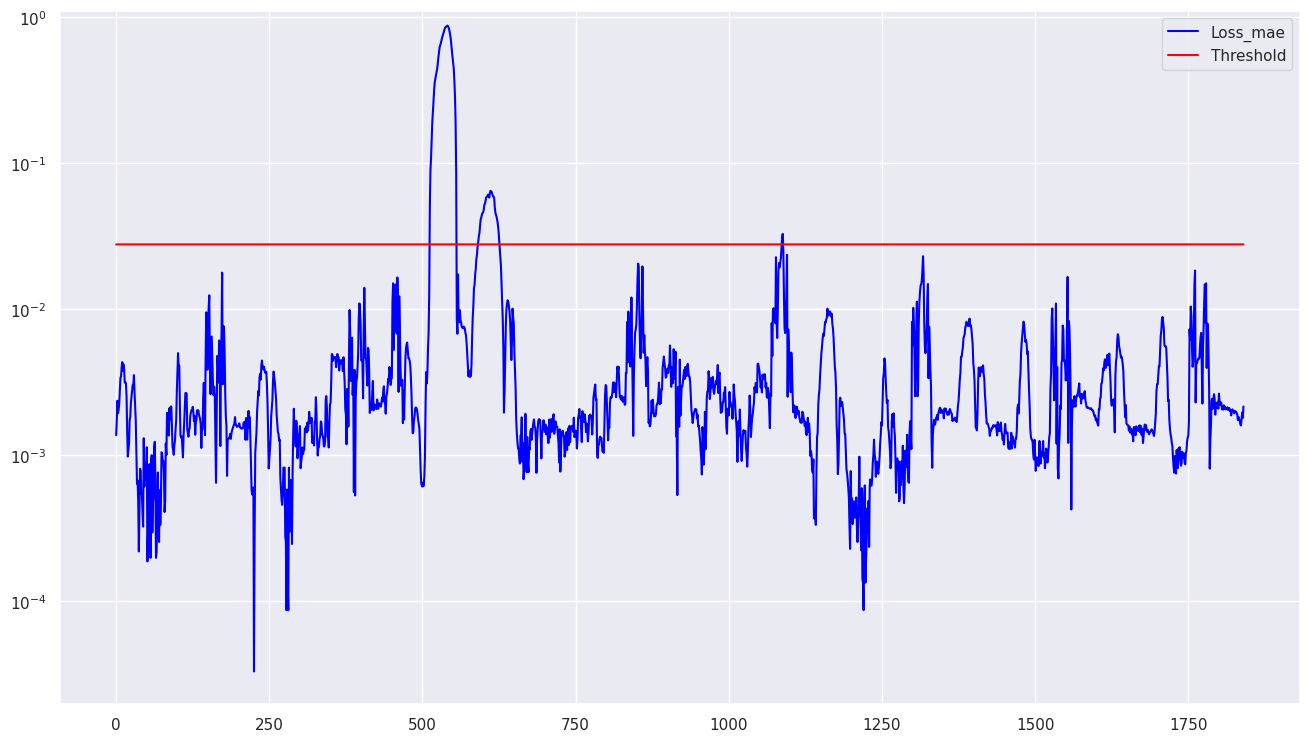

In [ ]:
# test set에 대한 결과
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

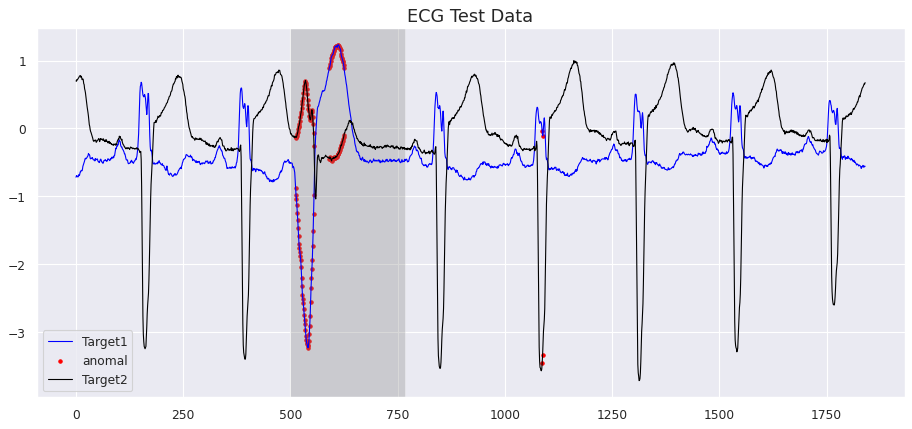

In [ ]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()

In [ ]:
# save all model information, including weights, in h5 format
model.save("ecg_model.h5")
print("Model saved")

Model saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
